In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

datasets = {}

In [2]:
# Parse data from Yahoo (1950 - now)
# https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
data = pd.read_csv('SP500-Yahoo.csv')
#data = data.resample('BM').apply(lambda x: x[-1])
data['Yield'] = data['Adj Close'].pct_change().fillna(0.0)
data = data[['Date', 'Yield']]
data['Inflation'] = 0.02 / 12 # Fixed inflation at 2%, we can do better if we use Shiller's data here
datasets['Yahoo'] = data
print("Data size for Yahoo's S&P 500 data is %d" % len(data.index))
data.tail(4)

Data size for Yahoo's S&P 500 data is 827


,Date,Yield,Inflation
823,2018-08-01,0.030263,0.001667
824,2018-09-01,0.004294,0.001667
825,2018-10-01,-0.071521,0.001667
826,2018-10-25,0.000000,0.001667


In [3]:
# Parse data from Shiller (1870 - now)
# http://www.econ.yale.edu/~shiller/data.htm
data = pd.read_csv("SP500-Shiller.csv", delimiter='\t')
data['Stock yield'] = data['P'].pct_change().fillna(0.0)
data['Div yield'] = (data['D'] / data['P']).fillna(0.0) / 12 # Shiller uses div yield of trailing 12 months
data['Inflation'] = data['CPI'].pct_change().fillna(0.0)
data['Yield'] =  data['Stock yield'] + data['Div yield']
data = data[['Date','Yield', 'Inflation']]

datasets['Shiller'] = data
print("Data size for Shiller's S&P 500 data is %d" % len(data.index))
data.tail(15)

Data size for Shiller's S&P 500 data is 1774


,Date,Yield,Inflation
1759,2017.08,0.002487,0.002994
1760,2017.09,0.016519,0.005295
1761,2017.10,0.027316,-0.000632
1762,2017.11,0.015882,0.000024
1763,2017.12,0.028801,-0.000588
1764,2018.01,0.048561,0.005448
1765,2018.02,-0.028810,0.004535
1766,2018.03,0.000658,0.002261
1767,2018.04,-0.016601,0.003975
1768,2018.05,0.019598,0.004159


In [4]:
def vermogensbelasting_2016(capital, gains=0):
    return max(0, round(0.012 * (capital-(2*24437)))) # met partner

assert vermogensbelasting_2016(0) == 0
assert vermogensbelasting_2016(150000) == 1214 # Belastingdienst.nl voorbeeld

vermogensbelasting_2016(1000000)

11414

In [5]:
# https://www.belastingdienst.nl/wps/wcm/connect/bldcontentnl/belastingdienst/prive/vermogen_en_aanmerkelijk_belang/vermogen/belasting_betalen_over_uw_vermogen/grondslag_sparen_en_beleggen/berekenen_belasting_over_uw_inkomsten_uit_vermogen_vanaf_2017/
def vermogensbelasting_2017(capital, gains=0):
    taxable = capital - 25000
    if taxable <= 0:
        return 0
    
    schijf_1 = min(75000, taxable)
    schijf_2 = max(min(975000, taxable)-75000, 0)
    schijf_3 = max(taxable - 975000, 0)
    
    return round((0.02871 * schijf_1 + 0.04600 * schijf_2 + 0.0539 * schijf_3) * 0.30)

assert vermogensbelasting_2017(0) == 0
assert vermogensbelasting_2017(125000) == 991
assert vermogensbelasting_2017(1250000) == 17108

In [4]:
# https://www.belastingdienst.nl/wps/wcm/connect/bldcontentnl/belastingdienst/prive/vermogen_en_aanmerkelijk_belang/vermogen/belasting_betalen_over_uw_vermogen/grondslag_sparen_en_beleggen/berekening-2018/
def vermogensbelasting_2018(capital, gains=0):
    taxable = capital - 30000
    if taxable < 0:
        return 0
    
    schijf_1 = min(70800, taxable)
    schijf_2 = max(min(978000, taxable)-70800, 0)
    schijf_3 = max(taxable - 978000, 0)
    
    return round((0.02017 * schijf_1 + 0.04326 * schijf_2 + 0.0538 * schijf_3) * 0.30)

assert vermogensbelasting_2018(0) == 0
assert vermogensbelasting_2018(130000) == 807
assert vermogensbelasting_2018(1255000) == 16189

In [5]:
def vennootschapsbelasting(capital, gains):
    schijf_1 = min(200000, gains)
    schijf_2 = max(gains-200000, 0)
    return round(max(0, 0.20 * schijf_1 + 0.25 * schijf_2))

assert vennootschapsbelasting(0, 200000) == 40000

In [36]:
dataset = datasets['Shiller']

def simulate(initial_capital, withdrawal_rate, duration_in_years=30, tax_fn=None):
    months = duration_in_years * 12
    initial_withdrawal = withdrawal_rate / 12 * initial_capital 
    initial_run_data = {'capital': initial_capital, 'withdrawal': 0, 'taxes': 0, 'gain': 0 }
   
    results = pd.DataFrame(index=np.arange(0, len(dataset) - months), data={'end_value': 0.0})
    
    for p in results.index:
        sample = dataset.iloc[p:p+months]
        
        run = pd.DataFrame(index=sample.index, data=initial_run_data)
        run['inflation']=  (1 + sample['Inflation']).cumprod()
        run['withdrawal'] = initial_withdrawal * run['inflation']
        run.index.name = 'month'    

        # loop over months & calculate capital value at each step
        capital = initial_capital
        for m in run.index:
            gain = capital * sample.at[m, 'Yield']

            # pay taxes every 12th month
            taxes = 0
            if tax_fn and m % 12 == 0:
                taxes = tax_fn(capital, gain)
    
            # store state for this month
            run.at[m, 'capital'] = capital
            run.at[m, 'taxes'] = taxes   
            run.at[m, 'gain'] = gain

            # calculate capital for next month
            # withdraw amount, add capital gains & pay taxes
            capital = capital + gain - taxes - run.at[m, 'withdrawal']
            
        results.at[p, 'end_value'] = capital    

                
    return results

def success_rate(results, min_capital=0):
    return results[results['end_value'] > min_capital].size / results.size

In [39]:
# Tax-free simulation with a 4% withdrawal rate over 30 years. 
# Should yield a success rate of about 98% (to match the Trinity study results)
res = simulate(1000000, 0.04, 30)
print("End value was higher than 0 in {0:.0%} of all simulations".format(success_rate(res, min_capital=0)))
print("End value was higher than initial capital (adjusted for inflation) in {0:.0%} of all simulations".format(success_rate(res, min_capital=1000000*pow(1.02, 30))))

End value was higher than 0 in 98% of all simulations
End value was higher than initial capital (adjusted for inflation) in 87% of all simulations


In [18]:
capital = 1200000 # initial capital
duration = 30 # years
withdrawal_rates = [3, 3.2, 3.4, 3.6, 3.8, 4, 4.2]

results = pd.DataFrame(index=withdrawal_rates)
for wr in results.index:
    run = simulate(capital*0.75, wr/100, duration, vermogensbelasting_2018)
    results.at[wr, 'vermogensbelasting 2018'] = success_rate(run) * 100
    
    run = simulate(capital, wr/100, duration, vennootschapsbelasting)
    results.at[wr, 'vennootschapsbelasting 2018'] = success_rate(run) * 100

results_30y_1200k = results

In [25]:
results_30y_1200k

,vermogensbelasting 2018,vennootschapsbelasting 2018
3.0,99.690881,99.768161
3.2,98.299845,99.690881
3.4,94.976816,99.304482
3.6,91.421947,98.222566
3.8,84.930448,95.440495
4.0,80.525502,92.272025


Text(0.5, 1.025, 'Vermogen = 900K prive / 1M zakelijk    Duur = 30 jaar')

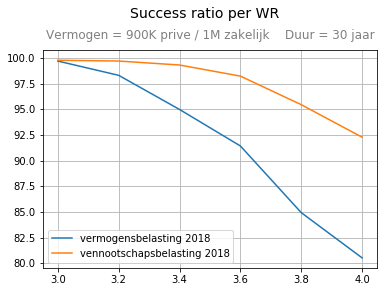

In [38]:
results_30y_1200k.plot(grid=True)
plt.suptitle("Success ratio per WR", y=1.03, fontsize=14)
plt.title("Vermogen = 900K prive / 1M zakelijk    Duur = 30 jaar", fontsize=12, y=1.025,  color='grey')

In [19]:
capital = 1200000 # initial capital
duration = 40 # years
withdrawal_rates = [3, 3.2, 3.4, 3.6, 3.8, 4]

results = pd.DataFrame(index=withdrawal_rates)
for wr in results.index:
    run = simulate(capital*0.75, wr/100, duration, vermogensbelasting_2018)
    results.at[wr, 'vermogensbelasting 2018'] = success_rate(run) * 100
    
    run = simulate(capital, wr/100, duration, vennootschapsbelasting)
    results.at[wr, 'vennootschapsbelasting 2018'] = success_rate(run) * 100
    
results_40y_1200k = results

In [22]:
results_40y_1200k

,vermogensbelasting 2018,vennootschapsbelasting 2018
3.0,99.690881,99.768161
3.2,98.299845,99.690881
3.4,94.976816,99.304482
3.6,91.421947,98.222566
3.8,84.930448,95.440495
4.0,80.525502,92.272025


Text(0.5, 1.02, 'Vermogen: €1.2M   Duur: 40 jaar')

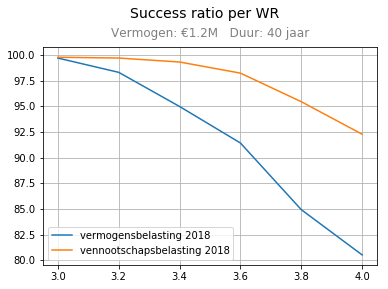

In [21]:
results_40y_1200k.plot(grid=True)
plt.suptitle("Success ratio per WR", y=1.02, fontsize=14)
plt.title("Vermogen: €1.2M   Duur: 40 jaar", fontsize=12, y=1.02, color='grey')

0.978076379066478
0.978076379066478
0.978076379066478
0.978076379066478
0.978076379066478
0.978076379066478
0.978076379066478
0.978076379066478
18.1 s ± 1.19 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
